This example was introduced in [BTV03] showing that there exists values of $\alpha$ for which the finiteness conjecture does not hold, that is, there is no $w = \sigma_1, \ldots, \sigma_k$ such that
$\sqrt[k]{\rho(A_{\sigma_k} \cdots A_{\sigma_1})}$ is equal to the JSR (such product is called a Spectral Maximizing Product (s.m.p.)).
Let $J_w \subseteq [0, 1]$ be the set of $\alpha$ such that $w$ is a s.m.p.
They show that for two words $u, v$ we have either $J_u = J_v$ (in which case $uuu\cdots$ and $vvv\cdots$ are identical up to a different prefix) or $J_u \cap J_v = \emptyset$.
In fact, let $\beta = \log(\alpha)$, since the function $h_w(\beta) = \log(\sqrt[|w|]{\rho(A_w)}) = \frac{1}{|w|}(\log(\rho(A_w)) + |w|_1 \beta)$ is affine in $\beta$, $J_u$ and $J_v$ can only be either equal, with empty intersection or with intersection equal to one of their two boundary points.
So [BTV03] excludes this last case.
The authors also mention that
$$ J_{0} = \{0\} \quad \text{ and } \quad J_1 = \emptyset. $$

The, in [Section V, GZ05], the authors show that
$$J_{10} = [4/5, 1] \quad \text{ and } \quad J_{100} \approx [0.5734, 0.7444] $$

It was then shown in [Section 6, GZ08] that for
$$J_{10010} =
\left[\frac{222924 - 23339 \sqrt{6}}{221184}, \frac{36864(222924 - 23339 \sqrt{6})}{7737809375} \right]
\approx [0.74940031328298342722, 0.789681582229248583974]$$

It was then proved in [HMST11] that the finiteness property does not hold for
$$\alpha = 0.749326546330367557943961948091344672091327370236064317358024...$$

[BTV03] V. D. Blondel, J. Theys and A. A. Vladimirov,
*An elementary counterexample to the finiteness conjecture*,
SIAM Journal on Matrix Analysis and Applications, **2003**. 24, 963-970.

[GZ05] N. Guglielmi and M. Zennaro.
*Polytope norms and related algorithms for the computation of the joint spectral radius*.
44th IEEE Conference on Decision and Control, and European Control Conference, **2005**, pp. 3007-3012.

[GZ08] N. Guglielmi and M. Zennaro.
*An algorithm for finding extremal polytope norms of matrix families*.
Linear Algebra and its Applications, **2008**, 428(10), 2265-2282.

[HMST11] K. G. Hare, I. D Morris, N. Sidorov and J. Theys,
*An explicit counterexample to the Lagarias–Wang finiteness conjecture*.
Advances in Mathematics, **2011**, 226(6), 4667-4701.

# Defining the system

We start by defining the system using [HybridSystems](https://github.com/blegat/HybridSystems.jl) to represent the system and [StaticArrays](https://github.com/JuliaArrays/StaticArrays.jl) for an allocation-free representation of the matrices.

In [2]:
using HybridSystems
using StaticArrays
A0 = @SMatrix [1 1; 0 1]
A1 = @SMatrix [1 0; 1 1]
A(α) = discreteswitchedsystem([A0, α * A1])
s1 = A(1.0)

Hybrid System with automaton OneStateAutomaton(2)

We define a convenient printing function for printing the s.m.p. candidate we find. 

In [3]:
using SwitchOnSafety
binstr(smp::SwitchOnSafety.DiscretePeriodicSwitching) = join(map(tr -> tr.σ - 1, smp.period))
function show_smp(smp)
    println("   SMP: ", binstr(smp))
    println("Length: ", length(smp.period))
    println("Growth: ", smp.growthrate)
end

show_smp (generic function with 1 method)

# Truncated $h$ functions

In [BTV03], the authors introduce the function $h(\beta) = \sup_{w} h_w(\beta)$ which is a convex continuous function.
We consider here truncated version of the $h$ function: $h^K(\beta) = \sup_{|w| \le K} h_w(\beta)$,
the functions $h^K$ are polyhedral function and the $J_w^K$ sets in $h^K$ are supersets of the real $J_w$ sets.
Moreover, they are all strict supersets on both extremities (except for $J_0$ at $\alpha=0$ or $\beta = -\infty$) as they cannot intersect.
So we know that there will always be a $K' > K$ such that each vertex of $h_K$ is cut at $h_{K'}$.

In [3]:
using SwitchOnSafety
# Represents a function h_w(β)
struct H{S}
    smp::SwitchOnSafety.DiscretePeriodicSwitching{S, HybridSystems.OneStateTransition}
    constant::Float64 # log(ρ(A_w))
    coefficient::Int  # |w|_1
    k::Int            # |w|
end
function H(w::Int, k)
    smp = periodicswitching(s1, [HybridSystems.OneStateTransition(((w >> i) & 1) + 1) for i in 0:(k-1)])
    constant = log(smp.growthrate) * k
    coefficient = count(tr -> tr.σ == 2, smp.period)
    H{typeof(s1)}(smp, constant, coefficient, k)
end
binstr(h::H) = binstr(h.smp)
heval(h::H, β::Float64) = (h.constant + h.coefficient * β) / h.k
# Computes the intersection point β of two functions h_{w_1} and h_{w_2},
# that is, the β such that h_{w_1}(β) = h_{w_2}(β)
function intersect(h1::H, h2::H)
    if h1.coefficient/h1.k == h2.coefficient/h2.k
        return -Inf
    else
        -(h1.constant/h1.k - h2.constant/h2.k) / (h1.coefficient/h1.k - h2.coefficient/h2.k)
    end
end
# Returns a vector of all h_w function for |w| ≤ K
function hs(K)
    h = Vector{H{typeof(s1)}}(undef, (1 << (K+1)) - 2)
    j = 0
    for k in 1:K
        for w in 0:((1 << k) - 1)
            j += 1
            h[j] = H(w, k)
        end
    end
    return h
end
# Returns the intersection points β and the indices of active w for h^K
function hs_β_smp(K)
    hs = Main.hs(K)
    smp0 = 1
    for i in 2:length(hs)
        if heval(hs[i], 0.0) ≈ heval(hs[smp0], 0.0)
            if hs[i].coefficient / hs[i].k < hs[smp0].coefficient / hs[i].k
                smp0 = i
            end
        else
            if heval(hs[i], 0.0) > heval(hs[smp0], 0.0)
                smp0 = i
            end
        end
    end
    smp = [smp0]
    β = [0.0]
    while smp[end] != 1
        smpnext = 1
        function obj(h::H)
            i = intersect(h, hs[smp[end]])
            if i > β[end] || i ≈ β[end]
                return -Inf
            end
            return i
        end
        for i in 2:length(hs)
            o = obj(hs[i])
            if o ≈ obj(hs[smpnext])
                if hs[i].coefficient / hs[i].k < hs[smp0].coefficient / hs[i].k
                    smpnext = i
                end
            else
                if o < obj(hs[smpnext])
                    smpnext = i
                end
            end
        end
        j = argmax(obj.(hs))
        push!(β, obj(hs[j]))
        @assert β[end] < β[end-1]
        push!(smp, j)
    end
    return hs, β, smp
end
# Represents a set J_w^k
struct J{S}
    h::H{S}
    αmin::Float64
    αmax::Float64
end
function js(K)
    hs, β, smp = hs_β_smp(K)
    @assert length(β) == length(smp)
    return map(i -> begin
        αmax = exp(β[i])
        if i == length(β)
            αmin = 0.0
        else
            αmin = exp(β[i+1])
        end
        return J(hs[smp[i]], αmin, αmax)
    end, length(β):-1:1)
end
function Base.show(io::IO, j::J)
    println(io, " smp: ", binstr(j.h))
    println(io, "From: ", j.αmin)
    println(io, "  To: ", j.αmax)
end

In [4]:
using Plots
pyplot()
# plots h^K(β)
function plot_hβ(K)
    hs, β, smp = hs_β_smp(K)
    @show β
    plot()
    for i in 1:length(β)
        βnext = i == length(β) ? β[i] - 1 : β[i + 1]
        h = hs[smp[i]]
        plot!([β[i], βnext], [heval(h, β[i]), heval(h, βnext)], label=binstr(h))
    end
    plot!()
end
# plots h^K(α)
function plot_hα(K)
    hs, β, smp = hs_β_smp(K)
    @show exp.(β)
    plot(xlim = (0.0, 1.0))
    for i in 1:length(β)
        βnext = i == length(β) ? β[i] - 1 : β[i + 1]
        h = hs[smp[i]]
        plot!([exp(β[i]), exp(βnext)], [heval(h, β[i]), heval(h, βnext)], label=binstr(h))
    end
    plot!()
end

plot_hα (generic function with 1 method)

We can see that the intervals are indeed supersets of the intervals given in [GZ05] and [GZ08].

In [8]:
js(5)

6-element Array{J{HybridSystem{OneStateAutomaton,MathematicalSystems.DiscreteIdentitySystem,MathematicalSystems.LinearDiscreteSystem{Float64,SArray{Tuple{2,2},Float64,2,4}},AutonomousSwitching}},1}:
  smp: 0
From: 0.0
  To: 0.1715728752538099
                    
  smp: 10000
From: 0.1715728752538099
  To: 0.45702943146534875

  smp: 1000
From: 0.45702943146534875
  To: 0.5669785102410742
 
  smp: 100
From: 0.5669785102410742
  To: 0.7463911219155626
   
  smp: 10100
From: 0.7463911219155626
  To: 0.7967176639288206
 
  smp: 10
From: 0.7967176639288206
  To: 1.0
                   

We can plot the function $h^K(\beta)$ which is indeed convex and the function $h^K(\alpha)$ which isn't.

β = [0.0, -0.227255, -0.292506, -0.567434, -0.783007, -1.76275]


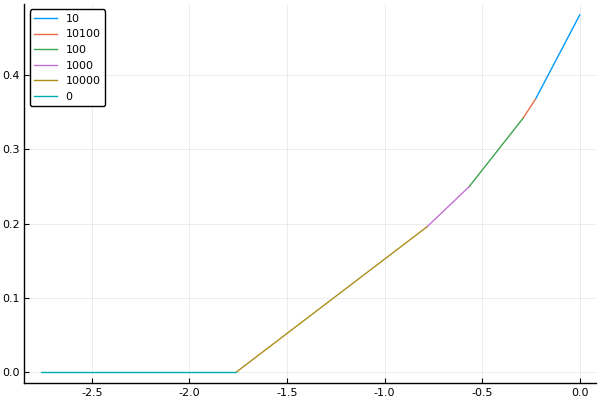

In [5]:
plot_hβ(5)

exp.(β) = [1.0, 0.796718, 0.746391, 0.566979, 0.457029, 0.171573]


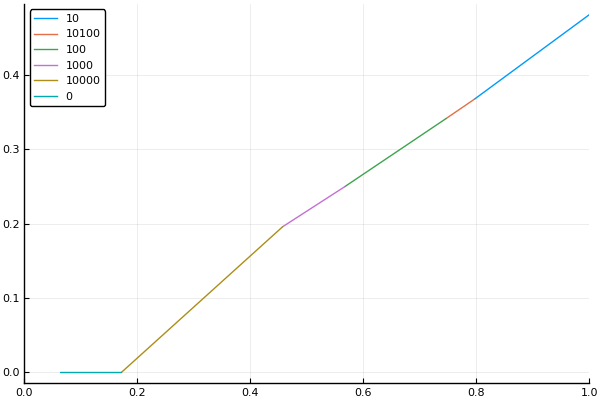

In [7]:
plot_hα(5)

# Getting close to non-finiteness

It was shown in [HMST11] that the finiteness conjecture does not hold for $\alpha = 0.749326546330367557943961948091344672091327370236064317358024$.
In a double-precision floating point number, the closest value we can represent is $\alpha = 0.7493265463303675$.
We create the switched system corresponding for this value of $\alpha$ and look for approximating the JSR for this value.

In [4]:
α∞ = 0.749326546330367557943961948091344672091327370236064317358024
@show significand(α∞)
@show exponent(α∞)
@show significand(α∞) / (1 << -exponent(α∞))
s∞ = A(α∞)

significand(α∞) = 1.498653092660735
exponent(α∞) = -1
significand(α∞) / (1 << -(exponent(α∞))) = 0.7493265463303675


Hybrid System with automaton OneStateAutomaton(2)

## Sum-of-Squares approach

We start with the Sum-of-Squares approach to have an idea of the value of the JSR.
We first choose an SDP solver.

In [7]:
using MathOptInterfaceMosek
using JuMP
factory = with_optimizer(MosekOptimizer, QUIET=true);

In [53]:
using SwitchOnSafety
lb = zeros(15)
ub = zeros(15)
function sos(d, tol; kws...)
    # Prevents the binary search to use a lower bound found by a cycle
    # to have to full timing of the binary search
    sosdata(s∞).lb = 0.0
    # Force recomputing it to have correct timing even when the function called twice with the same d
    if length(sosdata(s∞).lyaps) >= d
        sosdata(s∞).lyaps[d] = nothing
    end
    println("   Degree d: ", d)
    @time lb[d], ub[d] = soslyapb(s∞, d; factory=factory, tol=tol, verbose=1, kws...)
end

sos (generic function with 2 methods)

We start with degree $2d = 2$, i.e. the Common Quadratic Lyapunov Function (CQLF).

In [58]:
sos(1, 4e-8)

   Degree d: 1
Lower bound: 1.4264937524583678
Upper bound: 1.4264938090951405
Log-diff   : 3.9703483722952626e-8 ≤ 4.0e-8
  0.078548 seconds (136.90 k allocations: 12.064 MiB)


(1.008683405683556, 1.4264938090951405)

Using $l = 4$, the time taken to build the sequence is still neglibible to the time used to solve the SDP and the first 21 matrices of the sequence produces give a sequence of growth rate $1.4092$.

In [50]:
@time seq = sosbuildsequence(s∞, 1, niter=21, l=4, p_0=:Primal)
@time psw = findsmp(seq)
show_smp(psw)

  0.001386 seconds (27.56 k allocations: 1.584 MiB)
  0.000520 seconds (8.37 k allocations: 752.922 KiB)
   SMP: 010010100100101001001
Length: 21
Growth: 1.4092472220583487


With degree $2d = 4$, the upper bound gets closer to the lower bound given by the cycle of length 21 just found.

In [59]:
sos(2, 3e-8)

   Degree d: 2
Lower bound: 1.415875244461504
Upper bound: 1.415875286727847
Log-diff   : 2.985174202274621e-8 ≤ 3.0e-8
  0.105753 seconds (264.64 k allocations: 22.662 MiB, 5.22% gc time)


(1.1906044175141555, 1.415875286727847)

With $l=4$, we find the same cycle.

In [51]:
@time seq = sosbuildsequence(s∞, 2, niter=100, l=4, p_0=:Primal)
@time psw = findsmp(seq)
show_smp(psw)

  0.018201 seconds (254.39 k allocations: 15.831 MiB, 30.55% gc time)
  0.013571 seconds (155.21 k allocations: 16.153 MiB, 35.88% gc time)
   SMP: 010100100101001001010
Length: 21
Growth: 1.4092472220583487


We continue increasing the degree until $2d = 30$. The tolerance here were tuned by hand.

In [56]:
sos(3, 4e-6)
sos(4, 1e-5)
sos(5, 4e-4)
sos(6, 4e-4)
sos(7, 4e-4)
sos(8, 2e-4)
sos(9, 2e-4)
sos(10, 2e-4)
sos(11, 2e-4)
sos(12, 2e-4)
sos(13, 1e-4)
sos(14, 1e-4, scaling=1.41)
sos(15, 2e-4);

   Degree d: 3
Lower bound: 1.4128282163020807
Upper bound: 1.412832323892235
Log-diff   : 2.9073486328412557e-6 ≤ 4.0e-6
  0.086978 seconds (247.96 k allocations: 20.454 MiB, 6.32% gc time)
   Degree d: 4
Lower bound: 1.4117968151376181
Upper bound: 1.411809259753992
Log-diff   : 8.814697265768778e-6 ≤ 1.0e-5
  0.160244 seconds (500.25 k allocations: 39.960 MiB, 6.49% gc time)
   Degree d: 5
Lower bound: 1.410241058404017
Upper bound: 1.4107575986796927
Log-diff   : 0.0003662109375000555 ≤ 0.0004
  0.123199 seconds (620.20 k allocations: 45.094 MiB, 8.71% gc time)
   Degree d: 6
Lower bound: 1.4097951952539558
Upper bound: 1.41032348554655
Log-diff   : 0.0003746582031249335 ≤ 0.0004
  0.250244 seconds (1.17 M allocations: 83.482 MiB, 8.44% gc time)
   Degree d: 7
Lower bound: 1.4097247072564076
Upper bound: 1.4102410584040173
Log-diff   : 0.0003662109375000555 ≤ 0.0004
  0.228689 seconds (1.35 M allocations: 90.105 MiB, 8.80% gc time)
   Degree d: 8
Lower bound: 1.4097247072564076
Upp

We see the upper bounds for the different values of $d$ below:

In [60]:
ub

15-element Array{Float64,1}:
 1.4264938090951405
 1.415875286727847 
 1.412832323892235 
 1.411809259753992 
 1.4107575986796927
 1.41032348554655  
 1.4102410584040173
 1.4099828591935328
 1.4100300200534477
 1.4098968032956563
 1.4099828591935328
 1.4098968032956563
 1.409861556316163 
 1.4098547819537248
 1.4099828591935328

The best one is the following (we show two equivalent ways to obtain it):

In [63]:
minimum(ub), sosdata(s∞).ub

(1.4098547819537248, 1.4098547819537248)

The cycle found is till the same even with $2d = 30$.

In [62]:
@time seq = sosbuildsequence(s∞, 15, niter=100, l=4, p_0=:Primal)
@time psw = findsmp(seq)
show_smp(psw)

  1.367011 seconds (10.29 M allocations: 956.310 MiB, 13.09% gc time)
  0.008859 seconds (155.21 k allocations: 16.153 MiB)
   SMP: 010100100101001001010
Length: 21
Growth: 1.4092472220583487


In conclusion we know that the JSR is in the interval:

In [64]:
println("Lower bound: ", sosdata(s∞).lb)
println("Upper bound: ", sosdata(s∞).ub)

Lower bound: 1.4092472220583487
Upper bound: 1.4098547819537248


We can plot the lyapunov functions for increasing degrees as follows:

In [145]:
using MultivariatePolynomials
using Plots
function plot_lyap(p)
    d = mindegree(p)
    @assert d == maxdegree(p)
    @assert nvariables(p) == 2
    α = range(0., stop=2π, length=1000)
    X = cos.(α)
    Y = sin.(α)
    λ = map(x -> p(variables(p) => x), zip(X, Y))
    λ = λ.^(1/d)
    plot(X ./ λ, Y ./ λ, axis=false, aspect_ratio=:equal, label="", grid=false, border=nothing, ticks=nothing, linewidth=3)#, grid=false, label="")
    plot!(X, Y, label="", linestyle=:dash, linecolor=:black, linewidth=2)
end

plot_lyap (generic function with 1 method)

In [149]:
gr()
for d in 1:15
    plot_lyap(sosdata(s∞).lyaps[d].primal[1])
    savefig("FinConjCounterEx_d" * string(d) * ".pdf")
end

## Brute-force

A brute force search for a cycle with a better with length up to 32 shows that the cycle of length 21 found with $2d = 2$ is the best one up to length 32.
It remains unknown whether the cycle is an s.m.p.

In [18]:
using SwitchOnSafety
sosdata(s∞).smp = nothing
@time quicklb(s∞, 1:23)
show_smp(sosdata(s∞).smp)

 16.904939 seconds (326.30 M allocations: 19.173 GiB, 20.25% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [19]:
@time quicklb(s∞, 24)
show_smp(sosdata(s∞).smp)

 22.579059 seconds (505.57 M allocations: 27.854 GiB, 22.94% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [20]:
@time quicklb(s∞, 25)
show_smp(sosdata(s∞).smp)

 37.700757 seconds (639.70 M allocations: 39.097 GiB, 21.99% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [21]:
@time quicklb(s∞, 26)
show_smp(sosdata(s∞).smp)

 80.704443 seconds (1.45 G allocations: 86.021 GiB, 22.12% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [22]:
@time quicklb(s∞, 27)
show_smp(sosdata(s∞).smp)

158.086423 seconds (2.86 G allocations: 169.739 GiB, 22.24% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [11]:
@time quicklb(s∞, 28)
show_smp(sosdata(s∞).smp)

247.754003 seconds (6.93 G allocations: 393.833 GiB, 15.79% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [12]:
@time quicklb(s∞, 29)
show_smp(sosdata(s∞).smp)

451.648584 seconds (9.13 G allocations: 576.000 GiB, 14.99% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [13]:
@time quicklb(s∞, 30)
show_smp(sosdata(s∞).smp)

1108.237883 seconds (32.27 G allocations: 1.737 TiB, 18.45% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [14]:
@time quicklb(s∞, 31)
show_smp(sosdata(s∞).smp)

1700.920575 seconds (36.51 G allocations: 2.375 TiB, 16.06% gc time)
   SMP: 001001010010010100101
Length: 21
Growth: 1.4092472220583487


In [168]:
@time quicklb(s∞, 32)
show_smp(sosdata(s∞).smp)

6920.461502 seconds (110.85 G allocations: 6.402 TiB, 30.46% gc time)
   SMP: 010100100101001001010
Length: 21
Growth: 1.4092472220583487
